# General Dependencies

In [1]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [2]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [3]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

16:11:01 INFO    1204325400.py:12: WORKING!


# Setup

In [4]:
from time import sleep

from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks")


In [5]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

c:\Users\magod\anaconda3\envs\env_uma\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


16:11:07 INFO    ocr_local.py:131: OCRInterface initialized | lang=en device=cpu


In [6]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(ctrl=ctrl)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

16:11:07 INFO    yolo_local.py:30: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma.pt


# Lookup

19:32:50 DEBUG   29272047.py:105: Screen Detection: Unknown | {'training_buttons': 0, 'tazuna': False, 'infirmary': False, 'rest': False, 'rest_summer': False, 'recreation': False, 'race_day': False, 'counts': {'button_white': 2, 'skills_buy': 4, 'skills_square': 2, 'button_green': 1}}


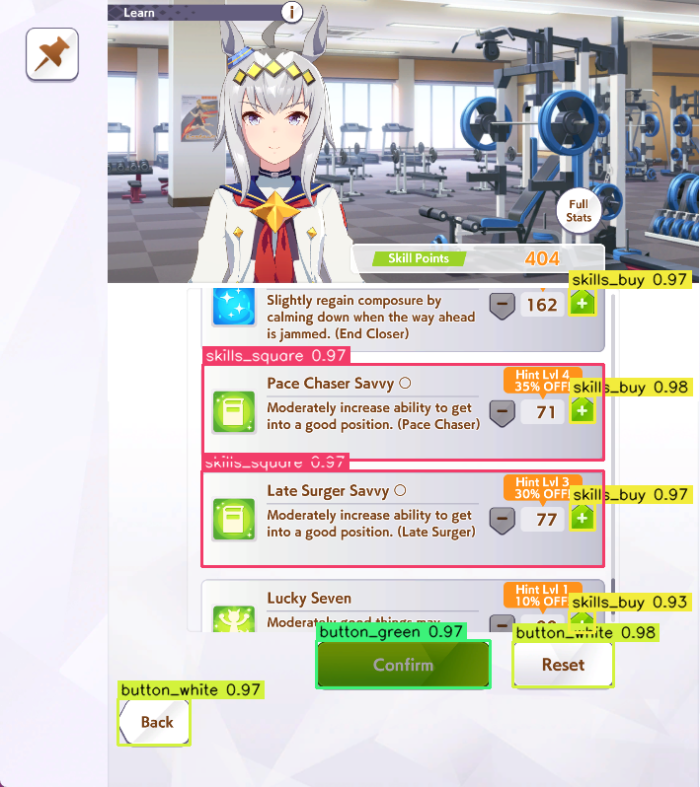

00 | button_white         | conf=0.982 | xyxy=(519.5,650.2,621.4,696.9)
01 | skills_buy           | conf=0.976 | xyxy=(577.0,401.6,603.0,428.4)
02 | skills_buy           | conf=0.974 | xyxy=(577.0,510.9,602.8,537.5)
03 | skills_buy           | conf=0.974 | xyxy=(576.8,292.7,603.1,319.9)
04 | button_white         | conf=0.972 | xyxy=(119.4,708.8,192.5,755.6)
05 | skills_square        | conf=0.971 | xyxy=(204.9,478.0,611.8,574.2)
06 | button_green         | conf=0.966 | xyxy=(320.3,650.0,496.9,697.7)
07 | skills_square        | conf=0.966 | xyxy=(205.7,369.8,611.2,466.3)
08 | skills_buy           | conf=0.930 | xyxy=(576.8,619.6,602.7,641.3)


In [13]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=param_conf,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


# Segment by segment testing

## Skills

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

skills_flow = SkillsFlow(ctrl, ocr, yolo_engine, waiter)
skills_flow.buy(skill_list=[
    "Focus"
])


## Races

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
# race_flow._ensure_in_raceday()
# race_flow.run(ensure_navigation=False, select_style="pace")
race_flow.lobby()

## Testing

## Agent

In [12]:
from __future__ import annotations

import time
from typing import List, Dict, Optional, Tuple
import random

import cv2
import numpy as np
from PIL import Image

from core.perception.extractors.training_metrics import extract_failure_pct_for_tile
from core.perception.yolo.interface import IDetector
from core.settings import Settings
from core.utils.analyzers import analyze_support_crop
from core.utils.geometry import calculate_jitter
from core.utils.logger import logger_uma
from typing import Any
from dataclasses import dataclass, asdict

# ---- knobs you may want to tweak later (kept here for clarity) ----
BASE_MAX_FAILURE = 20  # default risk cap (%) if not provided elsewhere
GREEDY_THRESHOLD = 2.5  # "pick immediately" threshold (if you use it)
HIGH_SV_THRESHOLD = 3.5  # when SV >= this, allow risk up to ×RISK_RELAX_FACTOR
RISK_RELAX_FACTOR = 1.5  # e.g., 20% -> 30% when SV is high

# Director scoring by bar color (latest rule you wrote)
DIRECTOR_SCORE_BY_COLOR = {
    "blue": 0.25,  # "blue or less"
    "green": 0.15,
    "orange": 0.10,
    "yellow": 0.00,  # max (or treat is_max as yellow)
    "max": 0.00,  # alias
}

# What counts as blue/green vs orange/max for the standard supports
BLUE_GREEN = {"blue", "green"}
ORANGE_MAX = {"orange", "yellow"}


@dataclass
class TileSV:
    tile_idx: int
    failure_pct: int
    risk_limit_pct: int
    allowed_by_risk: bool
    sv_total: float
    sv_by_type: Dict[str, float]
    greedy_hit: bool
    notes: List[str]

    def as_dict(self) -> Dict[str, Any]:
        d = asdict(self)
        # optional rounding/pretty-printing
        d["sv_total"] = float(f"{d['sv_total']:.2f}")
        d["sv_by_type"] = {k: float(f"{v:.2f}") for k, v in d["sv_by_type"].items()}
        return d


SUPPORT_NAMES = {
    "support_card",
    "support_card_rainbow",
    "support_etsuko",
    "support_director",
}


def _center(xyxy: Tuple[float, float, float, float]) -> Tuple[float, float]:
    x1, y1, x2, y2 = xyxy
    return (0.5 * (x1 + x2), 0.5 * (y1 + y2))


def _raised_training_ltr_index(
    parsed_objects_screen: List[Dict], tol_px: int = 3, tol_frac_h: float = 0.06
) -> Optional[int]:
    """
    Return the left-to-right index of the 'raised' training tile if one clearly stands out,
    else None. 'Raised' = top y noticeably smaller than the others.
    """
    btns = [d for d in parsed_objects_screen if d["name"] == "training_button"]
    if len(btns) < 2:
        return None

    tops = np.array([d["xyxy"][1] for d in btns], dtype=float)
    heights = np.array([d["xyxy"][3] - d["xyxy"][1] for d in btns], dtype=float)
    med_top = float(np.median(tops))
    min_top = float(np.min(tops))
    thr = max(float(tol_px), float(tol_frac_h) * float(np.median(heights)))

    if (med_top - min_top) > thr:
        xs = np.array([(d["xyxy"][0] + d["xyxy"][2]) * 0.5 for d in btns], dtype=float)
        ltr_idx = np.argsort(xs)
        btns_ltr = [btns[i] for i in ltr_idx]
        tops_ltr = [b["xyxy"][1] for b in btns_ltr]
        raised_idx_ltr = int(np.argmin(tops_ltr))
        return raised_idx_ltr

    return None


def _center_x(xyxy):
    x1, y1, x2, y2 = xyxy
    return 0.5 * (x1 + x2)

def scan_training_screen(
    ctrl,
    ocr,  # OCRInterface
    yolo_engine: IDetector,
    energy,
    *,
    pause_after_click_range: list = [0.3, 0.4],
    conf_support: float = 0.60,
) -> Tuple[List[Dict], Image.Image, List[Dict]]:
    """
    Efficient scan:
      • One initial capture.
      • If a tile is already raised, harvest it first (no click).
      • Then click each remaining tile exactly once; after each click:
          - recapture once,
          - refresh button geometry (LTR),
          - collect supports present in that capture (they belong to the raised tile),
          - extract failure%.
    Returns: (training_state, last_img, last_parsed)
    """
    # -------- detector params --------
    param_imgsz = 832
    param_conf = 0.60  # lower than 0.8 so we don't miss support cards
    param_iou = 0.45

    # -------- helpers --------
    def _center_x(xyxy):
        x1, _, x2, _ = xyxy
        return 0.5 * (x1 + x2)

    def _get_buttons_ltr(parsed_objs: List[Dict]) -> List[Dict]:
        btns = [d for d in parsed_objs if d["name"] == "training_button"]
        btns.sort(key=lambda d: _center_x(d["xyxy"]))
        return btns

    def _raised_training_ltr_index(
        parsed: List[Dict], tol_px: int = 3, tol_frac_h: float = 0.06
    ) -> Optional[int]:
        btns = [d for d in parsed if d["name"] == "training_button"]
        if len(btns) < 2:
            return None
        tops = np.array([d["xyxy"][1] for d in btns], dtype=float)
        heights = np.array([d["xyxy"][3] - d["xyxy"][1] for d in btns], dtype=float)
        med_top = float(np.median(tops))
        min_top = float(np.min(tops))
        thr = max(float(tol_px), float(tol_frac_h) * float(np.median(heights)))
        if (med_top - min_top) > thr:
            xs = np.array(
                [(d["xyxy"][0] + d["xyxy"][2]) * 0.5 for d in btns], dtype=float
            )
            order = np.argsort(xs)
            btns_ltr = [btns[i] for i in order]
            tops_ltr = [b["xyxy"][1] for b in btns_ltr]
            return int(np.argmin(tops_ltr))
        return None

    def _jitter_delay():
        if pause_after_click_range and len(pause_after_click_range) >= 2:
            a, b = float(pause_after_click_range[0]), float(pause_after_click_range[1])
            lo, hi = (a, b) if a <= b else (b, a)
            return max(0.0, random.uniform(lo, hi))
        return 0.6

    def _collect_supports_enriched(
        cur_img: Image.Image, cur_parsed: List[Dict]
    ) -> Tuple[List[Dict], bool]:
        """
        Take *all* supports visible in this capture — they correspond to the currently raised tile.
        Enrich each with bar/type pieces, hint, rainbow, etc.
        """
        frame_bgr = cv2.cvtColor(np.array(cur_img), cv2.COLOR_RGB2BGR)

        # --- helpers: IoU + NMS ---
        def _area(xyxy):
            x1, y1, x2, y2 = [float(v) for v in xyxy]
            return max(0.0, x2 - x1) * max(0.0, y2 - y1)

        def _iou(a, b):
            ax1, ay1, ax2, ay2 = [float(v) for v in a]
            bx1, by1, bx2, by2 = [float(v) for v in b]
            ix1, iy1 = max(ax1, bx1), max(ay1, by1)
            ix2, iy2 = min(ax2, bx2), min(ay2, by2)
            iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
            inter = iw * ih
            if inter <= 0.0:
                return 0.0
            ua = _area(a) + _area(b) - inter
            return inter / ua if ua > 0 else 0.0

        def _nms_by_iou(dets, iou_thr=0.50):
            """
            Class-agnostic NMS: keep highest-conf per overlap cluster.
            Each det: {"xyxy":[...], "conf":float, "name":str, ...}
            """
            if not dets:
                return dets
            # sort by confidence DESC (missing conf -> 0.0)
            ordered = sorted(dets, key=lambda d: float(d.get("conf", 0.0)), reverse=True)
            kept = []
            for d in ordered:
                dx = d.get("xyxy")
                if not dx:
                    continue
                drop = False
                for k in kept:
                    if _iou(dx, k.get("xyxy")) >= iou_thr:
                        drop = True
                        break
                if not drop:
                    kept.append(d)
            return kept

        # Raw supports filtered by confidence
        supports_raw = [
            d
            for d in cur_parsed
            if d["name"] in SUPPORT_NAMES and d.get("conf", 0.0) >= conf_support
        ]
        # De-duplicate overlaps (e.g., double rainbow hits)
        supports = _nms_by_iou(supports_raw, iou_thr=0.50)
        parts_bar = [d for d in cur_parsed if d["name"] == "support_bar"]
        parts_type = [d for d in cur_parsed if d["name"] == "support_type"]

        def _inside(inner, outer, pad=2):
            ix1, iy1, ix2, iy2 = inner
            ox1, oy1, ox2, oy2 = outer
            return (
                ix1 >= ox1 - pad
                and iy1 >= oy1 - pad
                and ix2 <= ox2 + pad
                and iy2 <= oy2 + pad
            )

        enriched: List[Dict] = []
        any_rainbow = False

        for s in supports:
            x1, y1, x2, y2 = [max(0, int(v)) for v in s["xyxy"]]
            crop = frame_bgr[y1:y2, x1:x2].copy()

            # parts within this support
            bar_xyxy = None
            type_xyxy = None
            for pb in parts_bar:
                bx1, by1, bx2, by2 = [int(v) for v in pb["xyxy"]]
                if _inside((bx1, by1, bx2, by2), (x1, y1, x2, y2), pad=1):
                    bar_xyxy = (bx1, by1, bx2, by2)
                    break
            for pt in parts_type:
                tx1, ty1, tx2, ty2 = [int(v) for v in pt["xyxy"]]
                if _inside((tx1, ty1, tx2, ty2), (x1, y1, x2, y2), pad=1):
                    type_xyxy = (tx1, ty1, tx2, ty2)
                    break

            bar_crop = (
                None
                if bar_xyxy is None
                else frame_bgr[
                    bar_xyxy[1] : bar_xyxy[3], bar_xyxy[0] : bar_xyxy[2]
                ].copy()
            )
            type_crop = (
                None
                if type_xyxy is None
                else frame_bgr[
                    type_xyxy[1] : type_xyxy[3], type_xyxy[0] : type_xyxy[2]
                ].copy()
            )

            attrs = analyze_support_crop(
                s["name"],
                crop,
                piece_bar_bgr=bar_crop,
                piece_type_bgr=type_crop,
            )

            has_rainbow = s["name"].endswith("_rainbow") or (s["name"] == "support_card_rainbow")
            any_rainbow |= has_rainbow

            enriched.append(
                {
                    **s,
                    "name": s["name"].replace("_rainbow", ""),  # normalize
                    "support_type": attrs["support_type"],
                    "support_type_score": attrs["support_type_score"],
                    "friendship_bar": attrs["friendship_bar"],
                    "has_hint": attrs["has_hint"],
                    "has_rainbow": bool(has_rainbow),
                }
            )

        return enriched, any_rainbow

    ENERGY_TO_IGNORE_FAILURE = 45

    def _failure_pct(cur_img, cur_parsed, tile_xyxy):
        if energy >= ENERGY_TO_IGNORE_FAILURE:
            return 0

        failure_predict = extract_failure_pct_for_tile(
            cur_img, cur_parsed, tile_xyxy, ocr
        )
        if failure_predict == -1:
            # try again
            time.sleep(0.2)
            failure_predict = extract_failure_pct_for_tile(
                cur_img, cur_parsed, tile_xyxy, ocr
            )

            if failure_predict == -1:
                failure_predict = Settings.MAX_FAILURE + 1

        return failure_predict

    # -------- 1) Initial capture, wait for button training animations --------
    time.sleep(0.3)
    cur_img, _, cur_parsed = yolo_engine.recognize(
        imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
    )

    btns = _get_buttons_ltr(cur_parsed)

    if btns and len(btns) != 5:
        time.sleep(0.5)
        # try again
        cur_img, _, cur_parsed = yolo_engine.recognize(
            imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
        )

        btns = _get_buttons_ltr(cur_parsed)
    if not btns:
        logger_uma.warning("No training buttons detected.")
        return [], cur_img, cur_parsed

    # Fixed LTR scaffold
    scan = [
        {
            "tile_idx": j,
            "tile_xyxy": btns[j]["xyxy"],
            "tile_center_x": float(_center_x(btns[j]["xyxy"])),
            "supports": [],
        }
        for j in range(len(btns))
    ]

    processed: set = set()
    results: List[Dict] = []

    # -------- 1.5) FAST_MODE: low-energy fast path (raised + WIT only) --------
    if Settings.FAST_MODE and isinstance(energy, (int, float)) and 0 <= int(energy) <= 35:
        # Identify raised and WIT (last) indices
        ridx_fast = _raised_training_ltr_index(cur_parsed)
        last_idx = len(scan) - 1 if len(scan) > 0 else None
        wanted = []
        if ridx_fast is not None and 0 <= ridx_fast < len(scan):
            wanted.append(("raised", ridx_fast))
        if last_idx is not None and (ridx_fast is None or last_idx != ridx_fast):
            wanted.append(("wit", last_idx))

        for tag_kind, idx in wanted:
            tile = scan[idx]
            if tag_kind == "raised":
                supps, any_rainbow = _collect_supports_enriched(cur_img, cur_parsed)
                results.append(
                    {
                        **tile,
                        "supports": supps,
                        "has_any_rainbow": any_rainbow,
                        "failure_pct": _failure_pct(cur_img, cur_parsed, tile["tile_xyxy"]),
                        "skipped_click": True,
                    }
                )
            else:
                # Click WIT (last) tile
                ctrl.click_xyxy_center(
                    tile["tile_xyxy"],
                    clicks=1,
                    jitter=calculate_jitter(tile["tile_xyxy"], percentage_offset=0.20),
                )
                time.sleep(_jitter_delay())
                cur_img, _, cur_parsed = yolo_engine.recognize(
                    imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
                )
                # Refresh LTR geometry
                btns_now = [d for d in cur_parsed if d["name"] == "training_button"]
                btns_now.sort(key=lambda d: _center_x(d["xyxy"]))
                if len(btns_now) == len(scan):
                    for j, b in enumerate(btns_now):
                        scan[j]["tile_xyxy"] = b["xyxy"]
                        scan[j]["tile_center_x"] = float(_center_x(b["xyxy"]))
                # Determine effective raised after click
                ridx_now = _raised_training_ltr_index(cur_parsed)
                eff_idx = ridx_now if (ridx_now is not None and 0 <= ridx_now < len(scan)) else idx
                eff_tile = scan[eff_idx]
                supps, any_rainbow = _collect_supports_enriched(cur_img, cur_parsed)
                results.append(
                    {
                        **eff_tile,
                        "supports": supps,
                        "has_any_rainbow": any_rainbow,
                        "failure_pct": _failure_pct(cur_img, cur_parsed, eff_tile["tile_xyxy"]),
                        "skipped_click": False,
                    }
                )

        results.sort(key=lambda r: r["tile_idx"])
        logger_uma.info(f"FAST MODE: Only analizing WIT, everything else may have high risk")
        return results, cur_img, cur_parsed

    # -------- 2) Already-raised tile (no click) --------
    ridx = _raised_training_ltr_index(cur_parsed)
    if ridx is not None and 0 <= ridx < len(scan):
        tile = scan[ridx]
        supps, any_rainbow = _collect_supports_enriched(cur_img, cur_parsed)
        tile_record = {
            **tile,
            "supports": supps,
            "has_any_rainbow": any_rainbow,
            "failure_pct": _failure_pct(cur_img, cur_parsed, tile["tile_xyxy"]),
            "skipped_click": False,
        }
        results.append(tile_record)
        processed.add(ridx)

        # -------- FAST_MODE: Greedy short-circuit --------
        if Settings.FAST_MODE:
            try:
                # Compute SV for just this tile and check greedy
                sv_rows_one = compute_support_values([tile_record])
                if sv_rows_one and sv_rows_one[0].get("greedy_hit", False):
                    
                    notes = sv_rows_one[-1].get("notes", "")
                    logger_uma.info(f"FAST MODE: Found a greedy training option, not analizing nothing more. notes={notes}")
                    # Return results so far, don't waste time checking other options; caller will act immediately
                    return results, cur_img, cur_parsed
            except Exception as e:
                # Never break scanning on SV errors; just continue
                logger_uma.error(f"Error while checking FAST_MODE greedy SV: {e}")

    # -------- 3) Visit remaining tiles exactly once --------
    for idx in range(len(scan)):
        if idx in processed:
            continue

        tile = scan[idx]
        # Click to raise this tile
        ctrl.click_xyxy_center(
            tile["tile_xyxy"],
            clicks=1,
            jitter=calculate_jitter(tile["tile_xyxy"], percentage_offset=0.20),
        )

        time.sleep(_jitter_delay())

        # Recapture once
        cur_img, _, cur_parsed = yolo_engine.recognize(
            imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
        )

        # Refresh geometry (LTR) to keep tile_xyxy up-to-date
        btns_now = _get_buttons_ltr(cur_parsed)
        if len(btns_now) == len(scan):
            for j, b in enumerate(btns_now):
                scan[j]["tile_xyxy"] = b["xyxy"]
                scan[j]["tile_center_x"] = float(_center_x(b["xyxy"]))
        else:
            logger_uma.warning(
                "Button count changed during scan: expected %d, got %d; keeping previous geometry",
                len(scan),
                len(btns_now),
            )

        # Whichever tile is raised after the click is the effective index
        ridx = _raised_training_ltr_index(cur_parsed)
        eff_idx = ridx if (ridx is not None and 0 <= ridx < len(scan)) else idx
        eff_tile = scan[eff_idx]

        supps, any_rainbow = _collect_supports_enriched(cur_img, cur_parsed)

        tile_record = {
            **eff_tile,
            "supports": supps,
            "has_any_rainbow": any_rainbow,
            "failure_pct": _failure_pct(cur_img, cur_parsed, eff_tile["tile_xyxy"]),
            "skipped_click": False,
        }
        results.append(tile_record)
        processed.add(eff_idx)

        # -------- FAST_MODE: Greedy short-circuit --------
        if Settings.FAST_MODE:
            try:
                # Compute SV for just this tile and check greedy
                sv_rows_one = compute_support_values([tile_record])
                if sv_rows_one and sv_rows_one[0].get("greedy_hit", False):
                    notes = sv_rows_one[-1].get("notes", "")
                    logger_uma.info(f"FAST MODE: Found a greedy training option, not analizing nothing more. notes={notes}")
                    # Return results so far, don't waste time checking other options; caller will act immediately
                    return results, cur_img, cur_parsed
            except Exception as e:
                # Never break scanning on SV errors; just continue
                logger_uma.error(f"Error while checking FAST_MODE greedy SV: {e}")

    results.sort(key=lambda r: r["tile_idx"])
    return results, cur_img, cur_parsed


def compute_support_values(training_state: List[Dict]) -> List[Dict[str, Any]]:
    """
    Compute Support Value (SV) per tile and apply the failure filtering rule.

    Inputs
    ------
    training_state : list[dict]
        Exactly the structure you pasted (each tile has 'supports', 'failure_pct', ...).

    Scoring Rules (as provided)
    ---------------------------
    • Each blue/green gauge support: +1  (per card)
    • If any blue/green support on the tile has a hint: +0.5 once (tile-capped) x2 if HINT_IS_IMPORTANT is True in Settings
    • Rainbow support (FT): +1 per rainbow card
      - Combo bonus: if >=2 rainbous, only add 0.5
    • Orange/Max gauge WITHOUT hint: +0  (no base)
      Orange/Max gauge WITH hint: +0.5 once (tile-capped, even if multiple)  x2 if HINT_IS_IMPORTANT is True in Settings
    • Reporter (support_etsuko): +0.1
    • Director (support_director): color-based
        blue: +0.25, green: +0.15, orange: +0.10, yellow/max: +0

    Failure rule
    ------------
    Let max_failure = BASE_MAX_FAILURE (20%) by default.
    - If SV < 3.5 → the tile must have failure_pct ≤ max_failure
    - If SV ≥ 3.5 → allow up to min(100, floor(max_failure * 1.5))

    Returns
    -------
    List[dict] with keys:
      - tile_idx, failure_pct, risk_limit_pct, allowed_by_risk
      - sv_total (float)
      - sv_by_type (dict[str,float])    # per support_type aggregation
      - greedy_hit (bool)               # SV ≥ GREEDY_THRESHOLD
      - notes (list[str])               # human-readable breakdown
    """
    out: List[TileSV] = []

    for tile in training_state:
        idx = int(tile.get("tile_idx", -1))
        failure_pct = int(tile.get("failure_pct", 0) or 0)
        supports = tile.get("supports", []) or []

        sv_total = 0.0
        sv_by_type: Dict[str, float] = {}
        notes: List[str] = []

        # Tile-level caps/flags
        any_bluegreen_hint = False
        any_orange_max_hint = False

        # For rainbow combo computation (per type)
        rainbow_count = 0

        # ---- 1) per-support contributions ----
        for s in supports:
            sname = s.get("name", "")
            # stype = s.get("support_type", "unknown") or "unknown"
            bar = s.get("friendship_bar", {}) or {}
            color = str(bar.get("color", "unknown")).lower()
            is_max = bool(bar.get("is_max", False))
            has_hint = bool(s.get("has_hint", False))
            has_rainbow = bool(s.get("has_rainbow", False))

            # Normalize 'max' color if flagged
            if is_max and color not in ("yellow", "max"):
                color = "yellow"

            # --- special cameos ---
            if sname == "support_etsuko":  # reporter
                sv_total += 0.1
                sv_by_type["special_reporter"] = (
                    sv_by_type.get("special_reporter", 0.0) + 0.1
                )
                notes.append("Reporter: +0.1")
                continue

            if sname == "support_director":
                # director score depends on color (blue/green/orange/yellow)
                score = DIRECTOR_SCORE_BY_COLOR.get(
                    color, DIRECTOR_SCORE_BY_COLOR.get("yellow", 0.0)
                )
                if score > 0:
                    sv_total += score
                    sv_by_type["special_director"] = (
                        sv_by_type.get("special_director", 0.0) + score
                    )
                    notes.append(f"Director ({color}): +{score:.2f}")
                else:
                    notes.append(f"Director ({color}): +0.00")
                continue

            # --- standard support cards (including rainbow variants) ---
            # Rainbow counts as +1 baseline
            if has_rainbow:
                sv_total += 1.0
                notes.append("rainbow: +1.00")
                rainbow_count = rainbow_count + 1
                # Rainbow hint does not add extra beyond standard tile-capped hint rules;
                # we still let hint rules below consider color buckets if needed.
                # (If you want rainbow to bypass color gates, keep as-is)

            # Blue/green baseline
            if color in BLUE_GREEN:
                sv_total += 1.0
                sv_by_type["cards"] = sv_by_type.get("cards", 0.0) + 1.0
                notes.append(f"{color}: +1.00")
                if has_hint:
                    any_bluegreen_hint = True
            # Orange/Max baseline is 0; only hint may help (tile-capped)
            elif color in ORANGE_MAX or is_max:
                if has_hint:
                    any_orange_max_hint = True
                notes.append(f"{color}: +0.00")
            else:
                notes.append(f"{color}: +0.00 (unknown color category)")

        # ---- 2) tile-capped hint bonuses ----
        if any_bluegreen_hint:
            hint_value = 0.75
            if Settings.HINT_IS_IMPORTANT:
                hint_value *= 3
            sv_total += hint_value
            sv_by_type["hint_bluegreen"] = (
                sv_by_type.get("hint_bluegreen", 0.0) + hint_value
            )
            notes.append(
                f"Hint on blue/green (tile-capped): +{hint_value}. Settings.HINT_IS_IMPORTANT={Settings.HINT_IS_IMPORTANT}"
            )

        if any_orange_max_hint:
            hint_value = 0.5  # Not as valuable as blue green hints
            if Settings.HINT_IS_IMPORTANT:
                hint_value = 0.75
                hint_value *= 3
            sv_total += hint_value
            sv_by_type["hint_orange_max"] = (
                sv_by_type.get("hint_orange_max", 0.0) + hint_value
            )
            notes.append(
                f"Hint on orange/max (tile-capped): +{hint_value}. Settings.HINT_IS_IMPORTANT={Settings.HINT_IS_IMPORTANT}"
            )

        # ---- 3) rainbow combo bonus (per type) ----

        if rainbow_count >= 2:
            # +0.5 for each *type* that has ≥2 rainbow cards
            combo_bonus = 0.5
            sv_total += combo_bonus
            sv_by_type["rainbow_combo"] = (
                sv_by_type.get("rainbow_combo", 0.0) + combo_bonus
            )
            notes.append(f"Rainbow combo +{combo_bonus}")

        # ---- risk gating with dynamic relax based on SV ----
        base_limit = BASE_MAX_FAILURE
        # Piecewise multiplier:
        #   SV ≥ 4.0 → x2.0
        #   SV > 3.0 → x1.5
        #   SV ≥ 2.5 → x1.25
        #   else     → x1.0
        if sv_total >= 4.0:
            risk_mult = 2.0
        elif sv_total > 3.0:
            risk_mult = 1.5
        elif sv_total >= 2.5:
            risk_mult = 1.25
        else:
            risk_mult = 1.0

        risk_limit = int(min(100, base_limit * risk_mult))
        allowed = failure_pct <= risk_limit
        notes.append(f"Dynamic risk: SV={sv_total:.2f} → base {base_limit}% × {risk_mult:.2f} = {risk_limit}%")

        # ---- 5) greedy mark (optional early exit logic can use this) ----
        greedy_hit = (sv_total >= GREEDY_THRESHOLD) and allowed
        if greedy_hit:
            notes.append(
                f"Greedy hit: SV {sv_total:.2f} ≥ {GREEDY_THRESHOLD} and failure {failure_pct}% ≤ {risk_limit}%"
            )

        out.append(
            TileSV(
                tile_idx=idx,
                failure_pct=failure_pct,
                risk_limit_pct=risk_limit,
                allowed_by_risk=bool(allowed),
                sv_total=float(sv_total),
                sv_by_type=sv_by_type,
                greedy_hit=greedy_hit,
                notes=notes,
            )
        )

    # Return simple dicts for convenience in notebooks / JSON
    return [t.as_dict() for t in out]


In [9]:
# core\actions\training_policy.py
from __future__ import annotations

import enum
import random
import re
from dataclasses import dataclass
from time import sleep
from typing import Any, Dict, List, Optional, Sequence, Tuple

from PIL import Image
# from core.actions.training_check import compute_support_values, scan_training_screen
from core.constants import DEFAULT_TILE_TO_TYPE, MOOD_MAP
from core.utils.date_uma import DateInfo, is_final_season, is_junior_year, is_pre_debut, is_summer, is_summer_in_next_turn, is_summer_in_two_or_less_turns, near_mood_up_event, parse_career_date
from core.utils.logger import logger_uma
from core.settings import Constants, Settings
from core.utils.race_index import RaceIndex, date_key_from_dateinfo

# ---------- Action Enum ----------


class TrainAction(enum.Enum):
    """Atomic decisions for the training turn."""

    # Tile-targeting actions (return a tile_idx)
    TRAIN_MAX = "train_max"  # train the highest-SV tile (risk-allowed)
    TRAIN_WIT = "train_wit"  # specifically train WIT tile
    TRAIN_DIRECTOR = "train_director"  # train where Director is (special rule)
    TAKE_HINT = "take_hint"  # train any tile that has a hint

    # Non-tile actions (tile_idx=None)
    REST = "rest"
    RECREATION = "recreation"
    RACE = "race"
    SECURE_SKILL = "secure_skill"  # late-game safety: ensure 1200/600
    NOOP = "noop"  # fallback (should not normally happen)


# ---------- Date parsing & helpers ----------

def normalize_mood(mood: object) -> Tuple[str, int]:
    """
    Accepts either 'GOOD' or ('GOOD', 4) and returns ('GOOD', 4).
    """
    if isinstance(mood, (tuple, list)) and len(mood) >= 1:
        mtxt = str(mood[0]).upper()
        return (mtxt, MOOD_MAP.get(mtxt, -1))
    mtxt = str(mood).upper()
    return (mtxt, MOOD_MAP.get(mtxt, -1))


# ---------- Tile selection utilities ----------
def _best_tile(
    sv_rows: List[Dict],
    *,
    allowed_only: bool = True,
    min_sv: float = -1.0,
    prefer_types: Optional[Sequence[str]] = None,
    tile_to_type: Optional[Dict[int, str]] = None,
) -> Optional[int]:
    """
    Return the tile_idx with the highest SV (risk-allowed, if requested).
    Tie-break with prefer_types order if provided.
    """
    tile_to_type = tile_to_type or DEFAULT_TILE_TO_TYPE
    rows = [r for r in sv_rows if (r.get("sv_total", 0.0) >= min_sv)]
    if allowed_only:
        rows = [r for r in rows if r.get("allowed_by_risk", False)]

    if not rows:
        return None

    # Primary sort: SV desc; tie-break: by preference rank, then lowest failure
    def pref_rank(idx: int) -> int:
        if not prefer_types:
            return 999
        t = tile_to_type.get(idx, "zzz")
        return prefer_types.index(t) if t in prefer_types else 999

    rows_sorted = sorted(
        rows,
        key=lambda r: (
            -float(r.get("sv_total", 0.0)),
            pref_rank(int(r["tile_idx"])),
            float(r.get("failure_pct", 100)),
        ),
    )
    return int(rows_sorted[0]["tile_idx"])


def _best_wit_tile(
    sv_rows: List[Dict],
    *,
    allowed_only: bool = True,
    min_sv: float = 0.0,
    tile_to_type: Optional[Dict[int, str]] = None,
) -> Optional[int]:
    tile_to_type = tile_to_type or DEFAULT_TILE_TO_TYPE
    rows = [r for r in sv_rows if tile_to_type.get(int(r["tile_idx"])) == "WIT"]
    if allowed_only:
        rows = [r for r in rows if r.get("allowed_by_risk", False)]
    rows = [r for r in rows if r.get("sv_total", 0.0) >= min_sv]
    if not rows:
        return None
    rows_sorted = sorted(
        rows,
        key=lambda r: (
            -float(r.get("sv_total", 0.0)),
            float(r.get("failure_pct", 100)),
        ),
    )
    return int(rows_sorted[0]["tile_idx"])


def _any_wit_rainbow(
    sv_rows: List[Dict], tile_to_type: Optional[Dict[int, str]] = None
) -> bool:
    """
    Weak heuristic: look for 'rainbow:' in notes for WIT tile.
    (Works with the notes produced by your compute_support_values.)
    """
    tile_to_type = tile_to_type or DEFAULT_TILE_TO_TYPE
    for r in sv_rows:
        if tile_to_type.get(int(r["tile_idx"])) != "WIT":
            continue
        for note in r.get("notes") or []:
            if "rainbow" in note.lower():
                return True
    return False


def _tiles_with_hint(sv_rows: List[Dict]) -> List[int]:
    out = []
    for r in sv_rows:
        if any("hint" in (note.lower()) for note in (r.get("notes") or [])):
            out.append(int(r["tile_idx"]))
    return out


def _director_tile_and_color(
    sv_rows: List[Dict],
) -> Tuple[Optional[int], Optional[str]]:
    """
    Very light inference from notes: "Director (blue): +0.50" etc.
    Returns (tile_idx, color) or (None, None).
    """
    for r in sv_rows:
        for note in r.get("notes") or []:
            m = re.search(r"director\s*\((blue|green|orange|yellow|max)\)", note, re.I)
            if m:
                return int(r["tile_idx"]), m.group(1).lower()
    return None, None


# ---------- Main decision function ----------


def decide_action_training(
    sv_rows: List[Dict],
    *,
    mood,
    turns_left,
    career_date: DateInfo,
    energy_pct: int,
    prioritize_g1: bool,
    stats={},
    reference_stats={
        "SPD": 1150,
        "STA": 1000,
        "PWR": 530,
        "GUTS": 270,
        "WIT": 250,
    },
    # Tie-break context
    tile_to_type: Optional[Dict[int, str]] = None,
    priority_stats: Optional[Sequence[str]] = None,
    # Policy thresholds (can be tuned in config later)
    minimal_mood: str = "NORMAL",  # below this → recreation (if also < 'GREAT')
    max_pick_sv_top: float = 2.5,
    next_pick_sv_top: float = 2.0,
    late_pick_sv_top: float = 1.5,
    low_pick_sv_gate: float = 1.0,
    energy_rest_gate_lo: int = 35,  # early branch
    energy_rest_gate_mid: int = 50,  # URA branch
    energy_race_gate: int = 68,  # summer / late branch
    skip_race=False,
) -> Tuple[TrainAction, Optional[int], str]:
    """
    Return the decided action and the target tile index (or None when not applicable).
    The flow mirrors your diagrams; 'events check' nodes are ignored here.
    """

    # Normalize helpers
    tile_to_type = tile_to_type or DEFAULT_TILE_TO_TYPE
    priority_stats = list(
        priority_stats or ["SPD", "STA", "WIT", "PWR", "GUTS"]
    )  # sensible default
    for i in range(len(priority_stats)):
        priority_stats[i] = priority_stats[i].upper()

    for i in range(len(tile_to_type)):
        tile_to_type[i] = tile_to_type[i].upper()
    (mood_txt, mood_score) = normalize_mood(mood)

    if isinstance(career_date, str):
        di = parse_career_date(career_date)
    else:
        di = career_date

    # Collect reasoning as we go
    reasons: List[str] = []

    def because(msg: str) -> None:
        reasons.append(msg)

    # Convenience views
    allowed_rows = [r for r in sv_rows if r.get("allowed_by_risk", False)]
    sv_by_tile = {int(r["tile_idx"]): float(r.get("sv_total", 0.0)) for r in sv_rows}

    # -------- Cap-aware filtering (do not train stats already at/above reference) --------
    def _stat_of_tile(idx: int) -> str:
        return str(tile_to_type.get(int(idx), "")).upper()

    try:
        capped_stats = set()
        for k, target in (reference_stats or {}).items():
            kU = str(k).upper()
            cur = int(stats.get(kU, -1))
            if cur >= 0 and int(target) > 0 and cur >= int(target):
                capped_stats.add(kU)
    except Exception:
        capped_stats = set()

    def _exclude_capped(rows):
        return [r for r in rows if _stat_of_tile(int(r["tile_idx"])) not in capped_stats]

    allowed_rows_filtered = _exclude_capped(allowed_rows)

    # WIT helpers respect caps too
    best_wit_any = None if "WIT" in capped_stats else _best_wit_tile(
        sv_rows, allowed_only=True, min_sv=0.0, tile_to_type=tile_to_type
    )
    best_wit_low = None if "WIT" in capped_stats else _best_wit_tile(
        sv_rows, allowed_only=True, min_sv=low_pick_sv_gate, tile_to_type=tile_to_type
    )

    # Hinted tiles that pass risk AND are not capped
    hint_tiles = [
        t for t in _tiles_with_hint(sv_rows)
        if any((r["tile_idx"] == t) and r.get("allowed_by_risk", False) for r in sv_rows)
        and _stat_of_tile(int(t)) not in capped_stats
    ]
    best_allowed_tile_25 = _best_tile(
        allowed_rows_filtered,
        min_sv=max_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    best_allowed_tile_20 = _best_tile(
        allowed_rows_filtered,
        min_sv=next_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    best_allowed_any = _best_tile(
        allowed_rows_filtered,
        min_sv=-1.0,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )

    def sv_of(idx: Optional[int]) -> float:
        return sv_by_tile.get(int(idx), 0.0) if idx is not None else 0.0

    # -----------------------------
    # Top of the flow
    # -----------------------------

    # -------------------------------------------------
    # Distribution-aware nudge (before step 1)
    # If a top-3 priority stat is undertrained vs. reference distribution
    # by ≥ 7% and its best SV is within 1.5 of the best overall, pick it.
    # -------------------------------------------------
    UNDERTRAIN_DELTA = 0.07  # ≥ 7% gap vs reference share
    MAX_SV_GAP = 1.5

    try:
        # Consider only known stats (ignore -1/0)
        keys = ["SPD", "STA", "PWR", "GUTS", "WIT"]
        known_keys = [k for k in keys if max(0, int(stats.get(k, -1))) > 0]

        # If hint is important ignore undertrain stat check, prioritize hint
        if known_keys and not (Settings.HINT_IS_IMPORTANT and len(hint_tiles) > 0):
            # Normalize reference to the same subset
            ref_sum = sum(max(0, int(reference_stats.get(k, 0))) for k in known_keys)
            cur_sum = sum(max(0, int(stats.get(k, 0))) for k in known_keys)

            if ref_sum > 0 and cur_sum > 0:
                ref_dist = {
                    k: max(0, int(reference_stats.get(k, 0))) / ref_sum
                    for k in known_keys
                }
                cur_dist = {
                    k: max(0, int(stats.get(k, 0))) / cur_sum for k in known_keys
                }
                deltas = {
                    k: ref_dist[k] - cur_dist[k] for k in known_keys
                }  # +ve → undertrained
                logger_uma.debug(f"STATS deltas respect 'ideal' distribution: {deltas}")
                top3 = [
                    t.upper()
                    for t in (
                        priority_stats[:3] if priority_stats else ["SPD", "STA", "WIT"]
                    )
                ]
                cand = [
                    (k, deltas[k])
                    for k in known_keys
                    if k in top3 and deltas[k] >= UNDERTRAIN_DELTA
                ]

                if cand:
                    # Most undertrained among top-3 priorities
                    cand.sort(key=lambda kv: kv[1], reverse=True)
                    under_stat, gap = cand[0]

                    # Best allowed overall
                    top_allowed_idx = best_allowed_any
                    top_allowed_sv = sv_of(top_allowed_idx)

                    # Best allowed tile for that specific stat
                    def _best_tile_of_type(
                        rows, stat: str, min_sv: float, tmap: Dict[int, str]
                    ):
                        pool = [
                            r
                            for r in rows
                            if str(tmap.get(int(r["tile_idx"]), "")).upper()
                            == stat.upper()
                            and float(r.get("sv_total", 0.0)) >= min_sv
                        ]
                        if not pool:
                            return None, 0.0
                        rbest = max(pool, key=lambda rr: float(rr.get("sv_total", 0.0)))
                        return int(rbest["tile_idx"]), float(rbest.get("sv_total", 0.0))

                    # respect caps here by using allowed_rows_filtered
                    under_idx, under_sv = _best_tile_of_type(
                        allowed_rows_filtered, under_stat, -1.0, tile_to_type
                    )

                    gap_top_under = top_allowed_sv - under_sv
                    flexible_gap = MAX_SV_GAP

                    # Wit h at least some value, default >= 0.5
                    if under_idx is not None and under_sv and under_sv > 0:
                        if gap > UNDERTRAIN_DELTA * 1.5:
                            # accept more gap respect to best play
                            flexible_gap += 0.5
                        if gap > UNDERTRAIN_DELTA and (
                            (top_allowed_idx is None or gap_top_under < flexible_gap)
                            and under_sv >= max(0.5, low_pick_sv_gate / 2)
                        ):
                            because(
                                f"Undertrained {under_stat} by {gap:.1%} vs reference; "
                                f"choosing its best SV {under_sv:.2f} (overall best {top_allowed_sv:.2f}, flexible_gap < {flexible_gap})"
                            )
                            return (
                                TrainAction.TRAIN_MAX,
                                under_idx,
                                "; ".join(reasons),
                            )
                    else:
                        because(
                            f"Undertrained {under_stat} by {gap:.1%} vs reference; "
                            f"but the TOP option is better {top_allowed_sv:.2f}, gap={gap} ) or is not worth it to train under_stat"
                        )
    except Exception as _e:
        # Be permissive—never break the policy due to stats math
        because(f"Distribution check skipped due to stats error: {_e}")
    # 1) If max SV option is >= 2.5 → select TRAIN_MAX (tie → priority order)
    if best_allowed_tile_25 is not None:
        because(
            f"Top SV ≥ {max_pick_sv_top} allowed by risk → pick tile {best_allowed_tile_25}"
        )
        return (TrainAction.TRAIN_MAX, best_allowed_tile_25, "; ".join(reasons))

    because("Not a IMPRESIVE option to train (>= 2.5 in SV), checking for other oportunities")
    # 2) Mood check → recreation
    min_mood_score = MOOD_MAP.get(str(minimal_mood).upper(), 3)
    if (
        mood_score != -1
        and mood_score < min_mood_score
        and mood_score < MOOD_MAP["GREAT"]
    ):
        because(
            f"Mood {mood_txt} below minimal {minimal_mood} and < GREAT → recreation"
        )
        return (TrainAction.RECREATION, None, "; ".join(reasons))

    # 3) Summer close? (1 turn) → TRAIN_WIT if rest is excesive
    if is_summer_in_next_turn(di):
        because("Summer is in next turn")
        if energy_pct >= 75 and energy_pct <= 96:
            idx = _best_wit_tile(
                sv_rows, allowed_only=True, min_sv=0.0, tile_to_type=tile_to_type
            )
            if idx is not None:
                because(f"Summer in 1 turn and energy {energy_pct} % → recover a little with soft-skip with WIT")
                return (TrainAction.TRAIN_WIT, idx, "; ".join(reasons))
        elif energy_pct <= 70:
            because(f"Summer in 1 turn and energy {energy_pct} % → recover a lot with soft-skip with WIT")
            return (TrainAction.REST, None, "; ".join(reasons))


    # 4) Summer within ≤2 turns and (energy<=90 and WIT SV>=1) → TRAIN_WIT
    if is_summer_in_two_or_less_turns(di) and energy_pct <= 90:
        because("Summer is in ≤2 turns away, checking for good opportunities in with")
        idx = _best_wit_tile(
            sv_rows, allowed_only=True, min_sv=0.50, tile_to_type=tile_to_type
        )
        if idx is not None:
            because("Valuable WIT found for summer, SV >= 0.5")
            return (TrainAction.TRAIN_WIT, idx, "; ".join(reasons))

    # 6) If max SV option >= 2.0 → TRAIN_MAX
    if best_allowed_tile_20 is not None:
        because(
            f"Top SV ≥ {next_pick_sv_top} allowed by risk → tile {best_allowed_tile_20}"
        )
        return (TrainAction.TRAIN_MAX, best_allowed_tile_20, "; ".join(reasons))

    # 7) If prioritize G1 and not Junior Year AND there is a G1 today → RACE
    if (
        prioritize_g1
        and not is_junior_year(di)
        and di.month is not None
        and not skip_race
        and not is_final_season(di)
    ):
        dk = date_key_from_dateinfo(di)
        if dk and RaceIndex.has_g1(dk):
            because("Prioritize G1 enabled, G1 available today → try race")
            return (TrainAction.RACE, None, "; ".join(reasons))

    # Director rule (approximation—see)
    #    If Director is present and not max (color != yellow), date is within windows,
    #    AND the tile's stat is within the top-3 priority stats → TRAIN_DIRECTOR
    director_idx, director_color = _director_tile_and_color(sv_rows)
    if director_idx is not None and di.year_code == 3:
        if (di.month in (1, 2, 3) and director_color in ("blue",)) or (
            di.month in (9, 10, 11, 12) and director_color not in ("yellow", "max")
        ):
            # Validate index and map tile -> stat
            if isinstance(sv_rows, list) and 0 <= director_idx < len(sv_rows):
                dir_stat = str(tile_to_type.get(int(director_idx), "")).upper()
                top3_priorities = [s.upper() for s in (priority_stats or [])][:3]

                # Require Director tile to be one of the top-3 priority stats
                if dir_stat in top3_priorities:
                    # Also skip if this stat is capped already
                    if dir_stat in capped_stats and director_color not in ("orange", ):
                        because(f"Director present but {dir_stat} already at/above target and is not orange → skip Director rule")
                    else:
                        # Still respect risk for that tile:
                        if any(
                            (r.get("tile_idx") == director_idx) and r.get("allowed_by_risk", False)
                            for r in sv_rows
                        ):
                            because(
                                f"We should train with Director for extra bonuses; director color={director_color}; "
                                f"tile stat={dir_stat} in top-3 priorities {top3_priorities}; risk ok → tile {director_idx}"
                            )
                            return (
                                TrainAction.TRAIN_DIRECTOR,
                                director_idx,
                                "; ".join(reasons),
                            )
                else:
                    because(
                        f"Director present but tile stat {dir_stat} not in top-3 priorities {top3_priorities} → skip Director rule"
                    )

    # URA Finale branch
    if is_final_season(di):
        # No rest allowed for now
        if hint_tiles:
            hinted = max(hint_tiles, key=lambda t: sv_of(t))
            because("URA Finale: take available hint to get more discounts")
            return (TrainAction.TAKE_HINT, hinted, "; ".join(reasons))

        # Re-target inheritance thresholds in final season:
        # 1) For top-3 priority stats, pick the first whose current value < 600.
        #    (Ignore caps here; thresholds outrank reference targets in URA.)
        top3_prio = [s.upper() for s in (priority_stats or [])][:3]

        def _best_tile_of_type(rows, stat: str, min_sv: float, tmap: Dict[int, str]):
            pool = [
                r for r in rows
                if str(tmap.get(int(r["tile_idx"]), "")).upper() == stat.upper()
                and float(r.get("sv_total", 0.0)) >= min_sv
            ]
            if not pool:
                return None, 0.0
            rbest = max(pool, key=lambda rr: float(rr.get("sv_total", 0.0)))
            return int(rbest["tile_idx"]), float(rbest.get("sv_total", 0.0))

        # (a) push any top-3 stat to 600 first
        for stat_name in top3_prio:
            curv = int(stats.get(stat_name, -1))
            if curv >= 0 and curv < 600:
                idx600, sv600 = _best_tile_of_type(allowed_rows, stat_name, -1.0, tile_to_type)
                if idx600 is not None:
                    because(f"URA Finale: raise {stat_name} towards 600 (cur={curv}) → tile {idx600}")
                    return (TrainAction.TRAIN_MAX, idx600, "; ".join(reasons))

        # (b) if all ≥ 600, pick the top-3 stat closest to 1200 but < 1170
        near_candidates = []
        for stat_name in top3_prio:
            curv = int(stats.get(stat_name, -1))
            if curv >= 0 and curv < 1170:
                near_candidates.append((stat_name, curv))
        if near_candidates:
            # Choose the one with the largest current value (closest to 1200)
            target_stat = max(near_candidates, key=lambda kv: kv[1])[0]
            idx1170, sv1170 = _best_tile_of_type(allowed_rows, target_stat, -1.0, tile_to_type)
            if idx1170 is not None:
                because(f"URA Finale: push {target_stat} closer to 1200 (cur={int(stats.get(target_stat, -1))}) but <1170 → tile {idx1170}")
                return (TrainAction.TRAIN_MAX, idx1170, "; ".join(reasons))

        # (c) last resort in URA: WIT soft-skip if available (uses cap-aware best_wit_low above)
        if best_wit_low is not None:
            because("URA Finale: no threshold targets; soft-skip with WIT")
            return (TrainAction.TRAIN_WIT, best_wit_low, "; ".join(reasons))

    # 8) If energy <= 35% → REST
    if energy_pct <= energy_rest_gate_lo:
        because(f"Energy {energy_pct}% ≤ {energy_rest_gate_lo}% → rest")
        return (TrainAction.REST, None, "; ".join(reasons))

    # 9) Soft-skip: WIT SV >= 1.5 or WIT rainbow → TRAIN_WIT
    if _any_wit_rainbow(sv_rows, tile_to_type=tile_to_type):
        if best_wit_any is not None:
            because("WIT has rainbow support → Skip turn with little energy recover")
            return (TrainAction.TRAIN_WIT, best_wit_any, "; ".join(reasons))
    else:
        idx = _best_wit_tile(
            sv_rows,
            allowed_only=True,
            min_sv=1.5,
            tile_to_type=tile_to_type,
        )
        if idx is not None:
            because(
                f"Decent WIT SV ≥ {late_pick_sv_top} and risk ok → WIT (aka skip turn)"
            )
            return (TrainAction.TRAIN_WIT, idx, "; ".join(reasons))

    # 11)
    if best_wit_low is not None:
        because("The best decision is to skip turn with WIT training")
        return (TrainAction.TRAIN_WIT, best_wit_low, "; ".join(reasons))

    because("There is no value in training WIT, checking other options")
    # 12) If max SV ≥ 1.5 → TRAIN_MAX
    best_allowed_tile_15 = _best_tile(
        allowed_rows_filtered,
        min_sv=late_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    if best_allowed_tile_15 is not None:
        because(
            f"Top training SV ≥ {late_pick_sv_top} allowed by risk → tile {best_allowed_tile_15}"
        )
        return (TrainAction.TRAIN_MAX, best_allowed_tile_15, "; ".join(reasons))

    # 13) Mood < Great and NOT near mood-up window → RECREATION
    if (mood_score < MOOD_MAP["GREAT"]) and not near_mood_up_event(di):
        because(
            "Mood < GREAT and not near mood-up window → recreation for future better training bonus"
        )
        return (TrainAction.RECREATION, None, "; ".join(reasons))

    # 14) Summer gate: if NOT summer and energy >= 70 and NOT Junior Pre-Debut → RACE
    if (
        (not is_summer(di))
        and (energy_pct >= energy_race_gate)
        and (not is_pre_debut(di) or not is_junior_year(di))
        and not is_final_season(di)
    ):
        if not (is_junior_year(di) or is_pre_debut(di) or is_final_season(di)) and not skip_race:
            because(
                f"Not summer, energy ≥ {energy_race_gate}% and not Junior Pre-Debut → try race (collect skill pts + minimal stat)"
            )
            return (TrainAction.RACE, None, "; ".join(reasons))
        else:
            if skip_race:
                because("Racing is skipped for external reasons")
            else:
                because(
                    "Racing is canceled either for energy, comming summer or debut/junior year"
                )
    else:
        because(
            "Racing now is not recommended, either for future events of due to energy issue"
        )

    # 15) If max SV ≥ 1 and the stat is within first 3 priorities → TRAIN_MAX
    best_allowed_tile_10 = _best_tile(
        allowed_rows_filtered,
        min_sv=low_pick_sv_gate,
        prefer_types=priority_stats[:3],
        tile_to_type=tile_to_type,
    )
    if best_allowed_tile_10 is not None:
        because(
            f"Selecting any train SV ≥ {low_pick_sv_gate} on top-3 priority stat → tile {best_allowed_tile_10}"
        )
        return (TrainAction.TRAIN_MAX, best_allowed_tile_10, "; ".join(reasons))

    # 16) Fallback: TRAIN_WIT (skip-turn/low-value)
    if is_summer(di) and best_wit_any:
        because("Fallback (Summer): WIT to skip turn and get stats")
        return (TrainAction.TRAIN_WIT, best_wit_any, "; ".join(reasons))
    elif energy_pct <= 70:
        because(
            "Weak Turn, Opportunity cost if racing Instead of WIT, selecting rest because we can recover energy"
        )
        return (TrainAction.REST, None, "; ".join(reasons))
    elif best_allowed_any is not None:
        because("Last resort: take best allowed training")
        return (TrainAction.TRAIN_MAX, best_allowed_any, "; ".join(reasons))

    because("No allowed options → NOOP")
    return (TrainAction.NOOP, None, "; ".join(reasons))


def click_training_tile(
    ctrl,
    training_state: List[Dict],
    tile_idx: int,
    *,
    clicks_range: list = [3, 5],
    pause_after: Optional[float] = None,
) -> bool:
    """
    Click the center of the training tile at `tile_idx` using the controller.
    Expects `tile_xyxy` to be in last-screenshot coordinates (as produced by your scan).

    Returns True on success, False otherwise.
    """
    tile = None

    for t in training_state:
        if int(t.get("tile_idx", -1)) == int(tile_idx):
            tile = t
            break
    if not tile:
        logger_uma.error(
            "click_training_tile: tile_idx %s not found in training_state", tile_idx
        )
        return False

    xyxy = tile["tile_xyxy"]
    clicks = random.randint(clicks_range[0], clicks_range[1])

    # Click center in *screen* coords (helper translates last-screenshot -> screen)
    ctrl.click_xyxy_center(xyxy, clicks=clicks)

    sleep(pause_after or 0.2)
    return True


@dataclass
class TrainingDecision:
    action: "TrainAction"
    tile_idx: Optional[int]
    why: str
    training_state: Any
    last_img: Optional[Image.Image]
    last_parsed: Optional[List[dict]]
    sv_rows: List[dict]


def check_training(player, *, skip_race: bool = False) -> Optional[TrainingDecision]:
    """
    Only *decides* what to do on the Training screen.
    - Reads all state directly from `player` (no copies).
    - Returns None if we are not on the Training screen.
    - Does NOT perform clicks; the caller (Player) will act on the decision.

    The function expects:
      - player.ctrl, player.ocr
      - player.lobby.state.{energy, mood, turn, date_info}
      - player.stats (optional, used by your policy)
    """
    # 1) Snapshot the training screen and parse it
    training_state, last_img, last_parsed = scan_training_screen(
        player.ctrl,
        player.ocr,
        yolo_engine=player.yolo_engine,
        energy=(
            player.lobby.state.energy if player.lobby and player.lobby.state else None
        ),
    )

    if not training_state:
        logger_uma.error("[training] Not in training screen; cannot decide.")
        return None

    # 2) Compute SV rows
    sv_rows = compute_support_values(training_state)
    for r in sv_rows:
        logger_uma.info(
            f"View {Constants.map_tile_idx_to_type[r['tile_idx']]}: "
            f"SV={r['sv_total']:.2f}  "
            f"fail={r['failure_pct']}% (≤ {r['risk_limit_pct']}% ? {r['allowed_by_risk']})  "
            f"greedy={r['greedy_hit']}"
        )
        for note in r["notes"]:
            logger_uma.info(f"   - {note}")

    # 3) Build policy inputs from live player state
    mood = player.lobby.state.mood if player.lobby else ("UNKNOWN", -1)
    turns_left = player.lobby.state.turn if player.lobby else -1
    career_date = player.lobby.state.date_info if player.lobby else None
    energy_pct = player.lobby.state.energy if player.lobby else None
    stats = player.lobby.state.stats if player.lobby else None

    # 4) Decide the action (no side effects here)
    action, tidx, why = decide_action_training(
        sv_rows,
        mood=mood,
        turns_left=turns_left,
        career_date=career_date,
        energy_pct=energy_pct,
        prioritize_g1=player.prioritize_g1,
        stats=stats,
        tile_to_type=Constants.map_tile_idx_to_type,
        reference_stats=Settings.REFERENCE_STATS,
        priority_stats=Settings.PRIORITY_STATS,
        minimal_mood=Settings.MINIMAL_MOOD,
        skip_race=bool(skip_race),
    )
    logger_uma.info(
        "[training] Decision: %s  tile=%s because=|%s|", action.value, tidx, why
    )

    return TrainingDecision(
        action=action,
        tile_idx=tidx,
        why=why,
        training_state=training_state,
        last_img=last_img,
        last_parsed=last_parsed,
        sv_rows=sv_rows,
    )


In [10]:
# core/agent.py
from __future__ import annotations

from time import sleep

from core.actions.claw import ClawGame
from core.actions.events import click_top_event_choice
from core.actions.lobby import LobbyFlow
from core.actions.race import RaceFlow
from core.actions.skills import SkillsFlow
# from core.actions.training_policy import (
#     TrainAction,
#     click_training_tile,
#     check_training
# )
from core.controllers.base import IController
from core.perception.analyzers.screen import classify_screen
from core.perception.extractors.state import extract_goal_text, extract_skill_points, find_best
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector
from core.settings import Settings
from core.utils.logger import logger_uma
from typing import Optional
from core.utils.text import fuzzy_contains
from core.utils.waiter import PollConfig, Waiter
from core.actions.race import ConsecutiveRaceRefused
from core.utils.abort import abort_requested

class Player:
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        yolo_engine: IDetector,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig = PollConfig(
            imgsz=Settings.YOLO_IMGSZ,
            conf=Settings.YOLO_CONF,
            iou=Settings.YOLO_IOU,
            poll_interval_s=0.5,
            timeout_s=4.0,
            tag="player",
        ),
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh = 3,
        select_style = None
    ) -> None:
        self.ctrl = ctrl
        self.ocr = ocr
        self.yolo_engine = yolo_engine
        self.is_running = False
        self.imgsz = Settings.YOLO_IMGSZ
        self.conf = Settings.YOLO_CONF
        self.iou = Settings.YOLO_IOU
        self.prioritize_g1 = bool(prioritize_g1)
        self._skip_training_race_once = False
        self.plan_races = dict(plan_races or {})

        # Vision params used by Waiter & flows
        self.skill_list = skill_list or []

        self.auto_rest_minimum = auto_rest_minimum

        # Shared Waiter for the whole agent
        self.waiter = Waiter(self.ctrl, self.ocr, self.yolo_engine, waiter_config)

        # Flows
        self.race = RaceFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)
        self.lobby = LobbyFlow(
            self.ctrl,
            self.ocr,
            self.yolo_engine,
            self.waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            interval_stats_refresh=interval_stats_refresh,
            plan_races=self.plan_races,
        )
        self.skills_flow = SkillsFlow(self.ctrl, self.ocr, self.yolo_engine, self.waiter)
        
        self.claw_game = ClawGame(self.ctrl, self.yolo_engine)
        self.claw_turn = 0

        self._iterations_turn = 0
        self._minimum_skill_pts = int(minimum_skill_pts)
        self.patience = 0
        self.select_style = select_style
    
    def _desired_race_today(self) -> str | None:
        """
        If we have a planned race for today's date (Y{year}-{MM}-{half}),
        return its name; otherwise None.
        """
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        key = f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"
        plan = getattr(self.lobby, "plan_races", None) or self.plan_races
        race = plan.get(key)
        if race:
            logger_uma.info(f"[agent] Planned race for {key}: {race}")
        return race

    def _today_date_key(self) -> Optional[str]:
        di = getattr(self.lobby.state, "date_info", None)
        if not di or di.month is None or (getattr(di, "half", None) not in (1, 2)):
            return None
        return f"Y{di.year_code}-{int(di.month):02d}-{int(di.half)}"

    # --------------------------
    # Main loop
    # --------------------------
    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        while self.is_running:
            # Hard-stop hook (F2)
            if abort_requested():
                logger_uma.info("[agent] Abort requested; exiting main loop immediately.")
                break
            sleep(delay)
            img, _, dets = self.yolo_engine.recognize(
                imgsz=self.imgsz, conf=self.conf, iou=self.iou, tag="screen"
            )

            screen, _ = classify_screen(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            if unknown_screen:
                threshold = 0.65
                if self.patience > 20 == 0:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=("button_green", "race_after_next", "button_white"),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning("Stopping the algorithm just for safeness, nothing happened in 20 iterations")
                        self.is_running = False
                        break
                continue

            if screen == "Event":
                self.claw_turn = 0
                click_top_event_choice(self.ctrl, self.ocr, dets, conf_min=0.6)
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                inspiration = find_best(dets, "event_inspiration", conf_min=0.4)
                if inspiration:
                    self.ctrl.click_xyxy_center(inspiration["xyxy"], clicks=1)
                continue

            if screen == "Raceday":
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}")

                # If enough points, go to skills and auto-buy (unchanged logic)
                if self.lobby.state.skill_pts >= self._minimum_skill_pts and len(self.skill_list) > 0:
                    self.lobby._go_skills()

                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                career_date_raw = (self.lobby.state.career_date_raw or "")

                race_predebut = 'predebut' in career_date_raw.lower().replace("-", "")
                logger_uma.debug(f"Race day, is predebut= {race_predebut}")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = extract_goal_text(self.ocr, img, dets) or ""

                    
                    race_predebut = fuzzy_contains(self.lobby.state.goal.lower(), "junior make debut", threshold=0.8)
                    logger_uma.debug(f"Unknown date but  select_style= {self.select_style}. checking goal: {self.lobby.state.goal.lower()}. race debut?:{race_predebut}")

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    # Run RaceFlow; it will ensure navigation into Raceday if needed
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=self.select_style,
                        from_raceday=True,
                        reason="Pre-debut (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    # Mark raced on current date-key to avoid double-race if date OCR doesn't tick
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
                else:
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=None,
                        from_raceday=True,
                        reason="Normal (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue


            if screen == "Lobby" or is_lobby_summer:
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=True, is_g1_goal=True, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (G1 target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            try:
                                ok = self.race.run(
                                    prioritize_g1=self.prioritize_g1,
                                    is_g1_goal=False,
                                    desired_race_name=desired_race_name,
                                    date_key=self._today_date_key(),
                                    reason=f"Planned race: {desired_race_name}",
                                )
                            except ConsecutiveRaceRefused:
                                logger_uma.info("[lobby] Consecutive race refused on planned race → back & skip once.")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                continue
                            if not ok:
                                logger_uma.error(f"[race] Couldn't race {desired_race_name}")
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.mark_raced_today(self._today_date_key())

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(prioritize_g1=self.prioritize_g1, is_g1_goal=False, reason=self.lobby.state.goal)
                        except ConsecutiveRaceRefused:
                            logger_uma.info("[lobby] Consecutive race refused → back & skip once.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error("[lobby] Couldn't race (fans target). Backing out; set skip guard.")
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self._handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                if self.lobby._go_skills():
                    sleep(1.0)
                    bought = self.skills_flow.buy(self.skill_list)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    self.is_running = False  # end of career
                    logger_uma.info("Detected end of career")
                    
                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue
            
            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}")
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def _handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        if not self.is_running:
            return
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        if not self.is_running:
            return
        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx)
            if not ok:
                logger_uma.error("[training] Failed to click training tile idx=%s", tidx)
            return

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby (RaceFlow will navigate into Raceday)
                try:
                    if self.race.run(prioritize_g1=self.prioritize_g1, reason="Training policy → race"):
                        return
                except ConsecutiveRaceRefused:
                    logger_uma.info("[training] Consecutive race refused → back to training and skip once.")
                    self.lobby._go_back()
                    self.lobby._skip_race_once = True
                    self._skip_training_race_once = True
                    if self.lobby._go_training_screen_from_lobby(None, None):
                        decision2 = check_training(self, skip_race=True)
                        if decision2 and decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                            click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning("[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found).")
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if decision2.action.value in tile_actions_train and decision2.tile_idx is not None:
                        click_training_tile(self.ctrl, decision2.training_state, decision2.tile_idx)
                    else:
                        logger_uma.info("[training] Second decision after failed race: %s", decision2.action.value)
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")

    # ------------- Hard-stop helper -------------
    def emergency_stop(self) -> None:
        """Cooperative, best-effort immediate stop hook."""
        self.is_running = False
        try:
            # Release any possible held inputs if controller exposes such methods
            if hasattr(self.ctrl, "release_all"):
                self.ctrl.release_all()  # type: ignore[attr-defined]
        except Exception:
            pass

## RUN

In [11]:
from server.utils import load_config, ensure_config_exists
cfg = load_config()

Settings.apply_config(cfg or {})
Settings.FAST_MODE = True

# 4) Extract preset-specific runtime opts (skill_list / plan_races / select_style)
preset_opts = Settings.extract_runtime_preset(cfg or {})

# 5) Instantiate Player with runtime knobs from Settings + presets
player = Player(
    ctrl=ctrl,
    ocr=ocr,
    yolo_engine=yolo_engine,
    interval_stats_refresh=1,
    minimum_skill_pts=Settings.MINIMUM_SKILL_PTS,
    prioritize_g1=False,
    auto_rest_minimum=Settings.AUTO_REST_MINIMUM,
    plan_races=preset_opts["plan_races"],
    skill_list=preset_opts["skill_list"],
    select_style=preset_opts["select_style"],  # "end"|"late"|"pace"|"front"|None
)

player.run()

16:11:32 DEBUG   lobby.py:568: [date] prev: None. Cand: DateInfo(raw='Senior Year Late Apr', year_code=3, month=4, half=2). accepted: DateInfo(raw='Senior Year Late Apr', year_code=3, month=4, half=2)
16:11:32 INFO    lobby.py:569: [date] initial: None -> Y3-Apr-2
16:11:32 INFO    lobby.py:133: Date: DateInfo(raw='Senior Year Late Apr', year_code=3, month=4, half=2) | raw: Senior Year Late Apr
16:11:32 DEBUG   race_index.py:134: [RaceIndex] Loaded races: 61 dates, 283 names
16:11:32 INFO    1226741774.py:116: [agent] Planned race for Y3-04-2: Tenno Sho (Spring)
16:11:32 INFO    race.py:673: [race] RaceDay begin (prioritize_g1=False, is_g1_goal=False) | reason='Planned race: Tenno Sho (Spring)'
16:11:32 DEBUG   race.py:60: Looking for race buttons: Planned race: Tenno Sho (Spring)
16:11:32 DEBUG   race.py:69: Clicked 'RACES'. Fast-probing for squares vs penalty popup…
16:11:35 DEBUG   race.py:164: Racing with desired_race_name=Tenno Sho (Spring)
16:11:35 INFO    race.py:172: [race] Seek

KeyboardInterrupt: 

# END